<a href="https://colab.research.google.com/github/aryanganjiii/Timeseries-Forecasting/blob/main/Time_Series_Forecasting_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-Series Forecasting with LSTM

## Load Libabry

In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from datetime import datetime

## Load CSV File

In [2]:
df = pd.read_csv('/content/Vibration-Paya-line1.csv')
df

,dateTime,values
0,2023-09-01T03:35:00Z,2.77
1,2023-09-01T03:40:00Z,2.77
2,2023-09-01T03:45:00Z,2.77
3,2023-09-01T03:50:00Z,2.79
4,2023-09-01T03:55:00Z,2.77
...,...,...
794,2023-09-03T23:05:00Z,2.89
795,2023-09-03T23:10:00Z,2.89
796,2023-09-03T23:15:00Z,2.89
797,2023-09-03T23:20:00Z,2.89


## Format Timeline & Show Plot

In [3]:
df.index = pd.to_datetime(df['dateTime'], format='%Y-%m-%dT%H:%M:%SZ')

<Axes: xlabel='dateTime'>

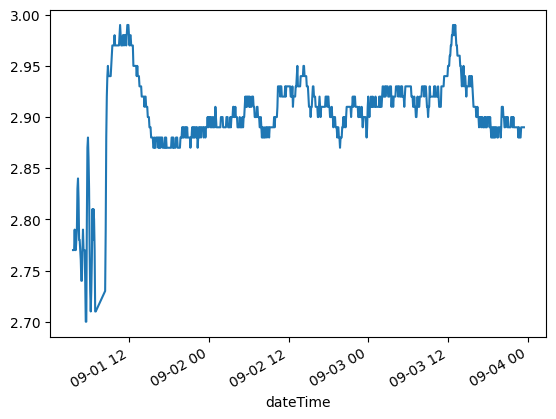

In [4]:
temp = df['values']
temp.plot()

## Time Series Dataframe to Input-Output Sequence Arrays Conversion

In [5]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

##  Generating Input-Output Sequence Arrays from Time Series Dataframe

In [6]:
WINDOW_SIZE = 1
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((798, 1, 1), (798,))

## Splitting Time Series Data into Training, Validation, and Test Sets

In [7]:
X_train1, y_train1 = X1[:700], y1[:700]
X_val1, y_val1 = X1[700:750], y1[700:750]
X_test1, y_test1 = X1[750:], y1[750:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((700, 1, 1), (700,), (50, 1, 1), (50,), (48, 1, 1), (48,))

## Design Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

bias_value = 0.1

model1 = Sequential()
model1.add(InputLayer((1, 1)))
model1.add(LSTM(80, return_sequences=True, bias_initializer=tf.keras.initializers.Constant(bias_value)))
model1.add(Dropout(0.3))
model1.add(LSTM(80, return_sequences=False, bias_initializer=tf.keras.initializers.Constant(bias_value)))
model1.add(Dense(31, activation='relu', bias_initializer=tf.keras.initializers.Constant(bias_value)))
model1.add(Dropout(0.3))
model1.add(Dense(1, activation='linear', bias_initializer=tf.keras.initializers.Constant(bias_value)))

model1.summary()




Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1, 80)             26240     
                                                                 
 dropout_10 (Dropout)        (None, 1, 80)             0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                51520     
                                                                 
 dense_10 (Dense)            (None, 31)                2511      
                                                                 
 dropout_11 (Dropout)        (None, 31)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 32        
                                                                 
Total params: 80303 (313.68 KB)
Trainable params: 8030

## Configuring Model Checkpoint and Compilation for Time Series Prediction Model

In [22]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)

model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

## Training Time Series Prediction Model with Model Checkpoint Callback

In [23]:
history=model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp1])



Epoch 1/50
22/22 [==============================] - 29s 1s/step - loss: 7.8220 - root_mean_squared_error: 2.7968 - val_loss: 7.4468 - val_root_mean_squared_error: 2.7289
Epoch 2/50
22/22 [==============================] - 8s 357ms/step - loss: 7.2008 - root_mean_squared_error: 2.6834 - val_loss: 6.8562 - val_root_mean_squared_error: 2.6184
Epoch 3/50
22/22 [==============================] - 9s 413ms/step - loss: 6.6310 - root_mean_squared_error: 2.5751 - val_loss: 6.2758 - val_root_mean_squared_error: 2.5051
Epoch 4/50
22/22 [==============================] - 8s 399ms/step - loss: 6.0683 - root_mean_squared_error: 2.4634 - val_loss: 5.6933 - val_root_mean_squared_error: 2.3861
Epoch 5/50
22/22 [==============================] - 8s 390ms/step - loss: 5.5136 - root_mean_squared_error: 2.3481 - val_loss: 5.1387 - val_root_mean_squared_error: 2.2669
Epoch 6/50
22/22 [==============================] - 9s 424ms/step - loss: 4.9443 - root_mean_squared_error: 2.2236 - val_loss: 4.5901 - val_ro

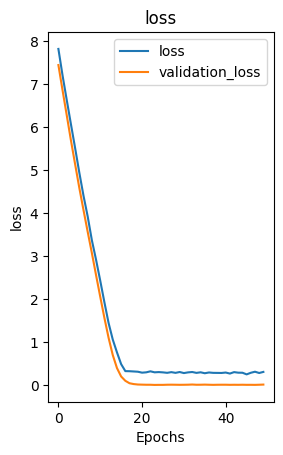

In [24]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="validation_loss")
plt.title("loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()

In [ ]:
train_predictions = model1.predict(X_train1).flatten()
print(len(train_predictions))
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

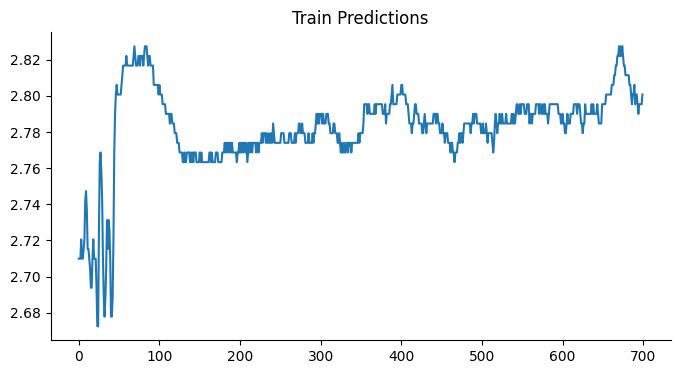

In [28]:
from matplotlib import pyplot as plt
train_results['Train Predictions'].plot(kind='line', figsize=(8, 4), title='Train Predictions')
plt.gca().spines[['top', 'right']].set_visible(False)

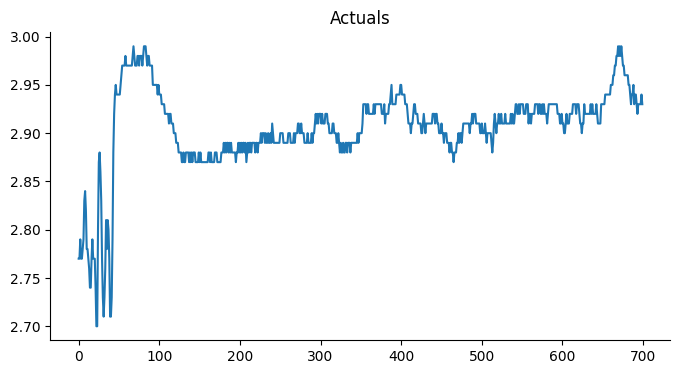

In [29]:
from matplotlib import pyplot as plt
train_results['Actuals'].plot(kind='line', figsize=(8, 4), title='Actuals')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
model1.save("model2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
